<a href="https://colab.research.google.com/github/bodorcy/hazifeladatok/blob/main/ml_4_feature_eng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Szöveges dokumentumok osztályozása
Olvasd el a [szövegbányászat](https://inf.u-szeged.hu/~rfarkas/ML20/NLP.html) előadás olvasóleckét.

Építsünk egy osztályozó gépi tanuló algoritmust, amit tanítunk, majd képes lesz korábban nem látott szövegekről döntést hozni, hogy azok pozitív, negatív vagy semleges véleményt fejeznek-e ki!

Töltsük le a tanító adatbázist:

In [30]:
import pandas as pd
train_data = pd.read_csv('https://github.com/rfarkas/student_data/raw/main/sentiment/train.tsv', sep='\t')
train_data.text[9062]

'Wtf!! somebody crashed a bad ass Audi! :O'

Hibaüzent :( Mi a hiba?

Ha a fájlt megnyitjuk akkor látjuk, hogy 3 oszlopot tartalmaz tabbal elválasztva (ezért tsv a kiterjesztés). A pandas.read_csv alapesetben vesszővel elválasztva várja a mezőket.

'Expected 2 fields in line 10, saw 4' Az első sor alapján a read_csv úgy gondolta, hogy két oszlop lesz, de a 10. sorban 4 oszlopot talált mert ott vesszők szerepeltek a szövegben...

**Érdemes rápillantani egy input filera mielőtt feldolgozni kezdjük!**

In [31]:
# ha a read_csv-nek megadjuk, hogy tab a separator akkor minden helyesen működik
train_data = pd.read_csv('https://github.com/rfarkas/student_data/raw/main/sentiment/train.tsv', sep='\t')
train_data

,id,label,text
0,225327940416712704,NEGATIVE,"HSBC 'sorry' for aiding Mexican drugs lords, r..."
1,210382999454367744,NEUTRAL,Bol d'Or 2003. See if you can spot the BMW Mot...
2,212454202176307202,POSITIVE,2002 TOYOTA CAMRY LE (CLEAN TITLE) (Chelsea) $...
3,215406031688314880,NEGATIVE,Bank of America to cut execs in wealth-managem...
4,209302409195954179,NEGATIVE,I just found out that lady gaga is number one ...
...,...,...,...
9058,210452067926556672,NEUTRAL,Car is so packed I can only see out of half of...
9059,218419311944019968,NEUTRAL,Yamaha Virago XV750 custom This Yamaha Virago ...
9060,211564279898439680,POSITIVE,2011 Jeep Grand Cherokee Laredo at Ingram Park...
9061,218218518041202688,NEGATIVE,#Barclays Bank fined for lying. #Capitalism in...


Értsük meg mi van az adatbázisban! Például milyen címkék (label) találhatóak benne?

<Axes: >

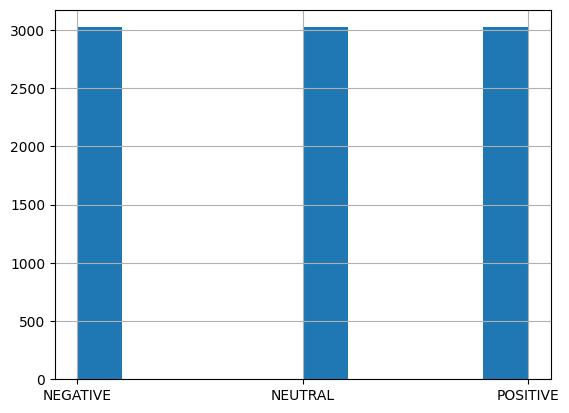

In [32]:
train_data.label.value_counts()
train_data.label.hist()

## Szózsák jellemzőtér

A dokumentumok lesznek a gépi tanulásban az egyedek. A legegyszerűbb jellemzőkészket amivel reprezentálni lehet egy dokumentumot az az egyes dokumentumban előforduló szavak gyakorisága. Minden az adatbázisban előforduló szóra felveszünk egy jellemzőt. Tfh az 'alma' szó szerepel a szótárunkban. Ekkor ha a dokumentumban kétszer fordul elő, akkor a jellemző értéke 2 lesz, ha pedig nem fordul elő akkor 0.

Ezt **szózsák reprezentációnak**nek (bag-of-words) is hívják, mivel olyan mintha a szavakat beöntenénk egy zsákba, elveszik azok sorrendisége (pl. nem mindegy 'not' és 'good' szavak egymás után fordultak-e elő) és pozíciója. De első gépi tanulási kísérletre pont jó :)

Az `sklearn`ben a szózsákot a `CountVectorizer` jelemzőkinyerő implementálja. Ez leszámolja a dokumentumok szavait és azokat `sklearn` jellemzőkké (feature) alakítja.

In [33]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

In [34]:
# fit: összegyűjti a szókincset, azaz minden tokent ami legalább egyszer előfordul az adatbázisban
vectorizer.fit(train_data.text)

CountVectorizer()

In [35]:
len(vectorizer.get_feature_names_out())

24285

In [36]:
vectorizer.vocabulary_ #ua, de itt a "szókincs" a jellemzőtér

{'hsbc': 10567,
 'sorry': 20519,
 'for': 8941,
 'aiding': 2854,
 'mexican': 14343,
 'drugs': 7567,
 'lords': 13322,
 'rogue': 19149,
 'states': 20822,
 'and': 3110,
 'terrorists': 21654,
 'http': 10581,
 'gu': 9857,
 'com': 6009,
 '394tx': 1480,
 'tw': 22474,
 'bol': 4431,
 'or': 16541,
 '2003': 973,
 'see': 19759,
 'if': 10777,
 'you': 24075,
 'can': 5081,
 'spot': 20693,
 'the': 21718,
 'bmw': 4362,
 'motorrad': 14883,
 'france': 9041,
 'team': 21542,
 'thevent': 21818,
 'rider': 18984,
 'https': 10583,
 'www': 23814,
 'facebook': 8409,
 'photo': 17225,
 'php': 17235,
 'fbid': 8555,
 '10151168605644619': 111,
 'set': 19850,
 '10151168601834619': 110,
 '545869': 1774,
 '223514989618': 1090,
 'type': 22542,
 '2002': 972,
 'toyota': 22175,
 'camry': 5078,
 'le': 12719,
 'clean': 5794,
 'title': 22002,
 'chelsea': 5550,
 '2700': 1207,
 'dlrd': 7349,
 'ms': 14988,
 'lpbohn': 13391,
 'cardeals': 5159,
 'bank': 3811,
 'of': 16301,
 'america': 3063,
 'to': 22041,
 'cut': 6671,
 'execs': 8276

In [37]:
# transform: végrehajtja a jellemzőkinyerést, azaz minden dokumentumhoz leszámolja minden szótárbeli szó gyakoriságát
features = vectorizer.transform(train_data.text)
features

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 147011 stored elements and shape (9063, 24285)>

A tanító adatbázisunk így 9063 egyedet tartalmaz (sorok) és 24285 jellemzőt (oszlopot). Azaz 24285 különböző token alkotja a szótárat. Mivel egy dokumentumban nagyon kevés szó fordul elő a 24285 szóból, ezért a jellemző mátrix túlnyomó része 0, ritka mátrixot használunk.

In [38]:
# fit_transform: a fit és transform egymás után futtatva
features = vectorizer.fit_transform(train_data.text)
features

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 147011 stored elements and shape (9063, 24285)>

## Lineáris gépek

**Tanítunk** egy ún. [lineáris gép osztályozó](https://inf.u-szeged.hu/~rfarkas/ML20/linearis_gep.html) modellt, a [stochastic gradient descend (SGD)](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html). Itt az elöző órán megismert döntési fát nem szerencsés használni mert nagyon sok jellemzőnk van és azok között megtanulni a kapcsolatot nagyon sok idő. Ilyenkor [lineáris osztályozókat](https://scikit-learn.org/stable/modules/linear_model.html) (SGD mellett például Logisztikus Regresszió) érdemes használni vagy olyan döntési fa variánsokat amik sok jellemzőre lettek kitalálva (pl. [xgboost](https://xgboost.readthedocs.io/)).

In [39]:
from sklearn.linear_model import SGDClassifier

cls = SGDClassifier()
model = cls.fit(features, train_data.label)

In [40]:
model.coef_.shape

(3, 24285)

Az egyes osztályok legerősebb jellemzői:

In [41]:
sorted(zip(model.coef_[2], vectorizer.get_feature_names_out()),reverse=False)[:10]

[(np.float64(-1.457970559998185), 'horse'),
 (np.float64(-1.3204261675455222), 'yamaha'),
 (np.float64(-1.2654084105644654), 'pep'),
 (np.float64(-1.2654084105644614), 'kill'),
 (np.float64(-1.237899532073928), 'versa'),
 (np.float64(-1.2103906535833964), 'jaguar'),
 (np.float64(-1.2103906535833953), 'barclays'),
 (np.float64(-1.18288177509287), 'mitsubishi'),
 (np.float64(-1.1828817750928666), '07'),
 (np.float64(-1.1278640181118031), 'accident')]

**Vizualizáljuk** a legerősebb jellemzőket!

In [42]:
import numpy as np

In [43]:
feature_names = vectorizer.get_feature_names_out()
feature_weights = cls.coef_

In [56]:
rows = np.concatenate([[feature_names], feature_weights]).T
columns = ["words"] + cls.classes_.tolist()

In [57]:
feature_df = pd.DataFrame(rows, columns=columns)
feature_df

,words,NEGATIVE,NEUTRAL,POSITIVE
0,00,-0.0407,-0.244449,0.027509
1,000,0.2849,-0.427785,0.330107
2,000k,0.0,-0.244449,0.165053
3,000th,0.1628,-0.275005,0.055018
4,001046825,0.0,0.0,0.0
...,...,...,...,...
24280,ラッキー,0.0,-0.366673,0.385124
24281,来自,-0.0814,-0.061112,0.110036
24282,東京都,0.0,-0.122224,0.137544
24283,江東区,0.0,-0.122224,0.137544


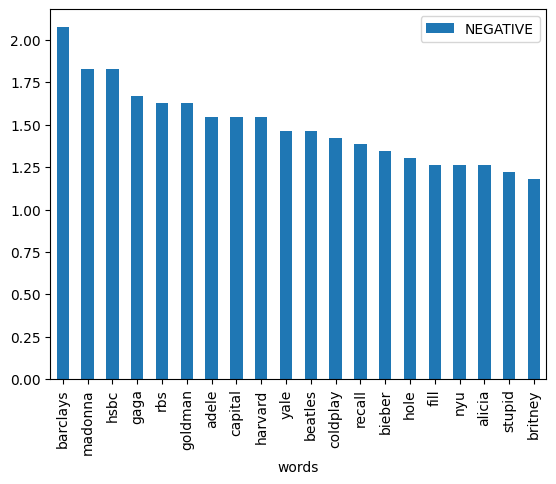

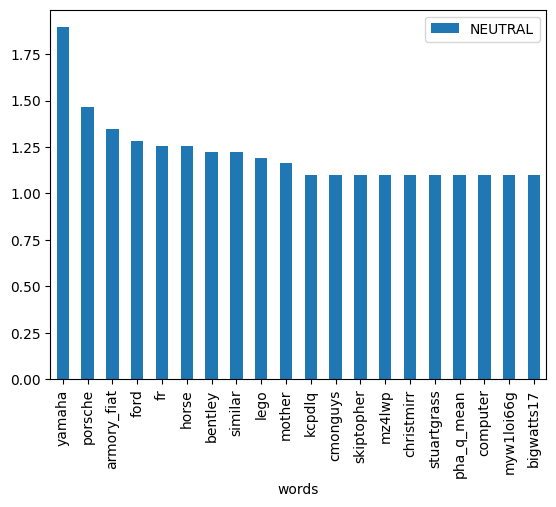

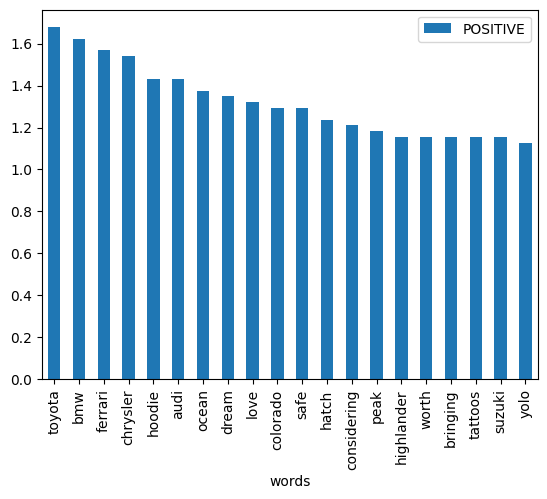

In [58]:
for class_label in cls.classes_:
  feature_df.sort_values(class_label, ascending=False)[:20].plot(kind="bar", x="words", y=class_label)

**Értékeljük ki**, hogy milyen pontos modellt tanítottunk ezen az adatbázison!

In [59]:
from sklearn.metrics import accuracy_score, classification_report

In [60]:
prediction = model.predict(features)
prediction # a predikció eredménye egy lista az egyedekre predikált címkékkel

array(['NEGATIVE', 'NEUTRAL', 'POSITIVE', ..., 'POSITIVE', 'NEGATIVE',
       'NEUTRAL'], dtype='<U8')

In [61]:
accuracy_score(y_true=train_data.label, y_pred=prediction)

0.9912832395454044

In [62]:
print(classification_report(y_true=train_data.label, y_pred=prediction))

              precision    recall  f1-score   support

    NEGATIVE       1.00      0.99      0.99      3021
     NEUTRAL       0.99      0.99      0.99      3021
    POSITIVE       0.99      0.99      0.99      3021

    accuracy                           0.99      9063
   macro avg       0.99      0.99      0.99      9063
weighted avg       0.99      0.99      0.99      9063



Megjegyzés: a tanító adatbázison való kiértékelésnek is van haszna. Ha nagyon alacsony értékeket kapunk az azt jelenti, hogy vagy jellemzőkészlet amit kinyertünk nem tartalmaz a tanuláshoz elég információt vagy a gépi tanuló modellt rosszul választottuk meg.

In [63]:
test_data = pd.read_csv('https://raw.githubusercontent.com/rfarkas/student_data/main/sentiment/test.tsv', sep='\t')

In [52]:
vectorizer2 = CountVectorizer()
test_features = vectorizer2.fit_transform(test_data.text)
prediction = model.predict(test_features)

ValueError: X has 7271 features, but SGDClassifier is expecting 24285 features as input.

Hibaüzenet :( Már megint...

`'X has 7271 features per sample; expecting 24285'`

Emlékezzünk vissza, hogy a `vectorizer.fit_transform` `fit`je először az adatbázisból elkészíti a szótárat (legalább egyszer előforduló szavak az egész adatbázisban). A test adatbázisban 7271 különböző szó fordult elő. Így a test adatbázis jellemzőkészlete (`test_features`) nem kompatibilis a `model` jellemzőkészletével ami 24285 dimenziós. Fontos, hogy a tanító adatbázison kialakított jellemzőkészletet használjuk a test adatbázison is!

In [64]:
test_features = vectorizer.transform(test_data.text)
prediction = model.predict(test_features)

In [65]:
test_features

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 21551 stored elements and shape (1500, 24285)>

In [66]:
accuracy_score(y_true=test_data.label, y_pred=prediction)

0.77

Jelen esetben a konstans baseline accuracy-ja 0.333 lenne, úgyhogy kijelenthetjük, hogy a modell tanult valamit :)

De azért a baseline-t mérjük ki hivatalosan is:

In [67]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent") # tanító adatbázis leggyakoribb osztálya lesz mindig a predikció
dummy_clf.fit(features, train_data.label) # ugyanazon a tanító adatbázison "tanítjuk"
baseline_prediction = dummy_clf.predict(test_features) # predikció a kiértékelő adatbázison
accuracy_score(baseline_prediction, test_data.label)

0.3333333333333333

In [68]:
## Az SGDClassifier-ben a loss és az alpha beállításával tudjuk elkerülni a túltanulást
## Ezt hívjuk regularizációnak lineáris gépeknél
cls = SGDClassifier(alpha=0.001)
model = cls.fit(features, train_data.label)
prediction = model.predict(test_features)
accuracy_score(y_true=test_data.label, y_pred=prediction)

0.7873333333333333

In [69]:
#egy másik lineáris gép osztályozó
from sklearn.linear_model import LogisticRegression
cls = LogisticRegression()

## Tévesztési mátrix

In [70]:
print(classification_report(y_true=test_data.label, y_pred=prediction))

              precision    recall  f1-score   support

    NEGATIVE       0.93      0.84      0.88       500
     NEUTRAL       0.75      0.72      0.74       500
    POSITIVE       0.70      0.80      0.75       500

    accuracy                           0.79      1500
   macro avg       0.80      0.79      0.79      1500
weighted avg       0.80      0.79      0.79      1500



Látszik, hogy a negatív osztályt valamiért könnyebben megtanulja, mind a precision, mind a recall jobb ott, mint a másik két osztályon...

A tévesztési (confusion) mátrix megmutatja, hogy melyik osztályt melyik másik osztállyal téveszti össze a modell:

In [71]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true=test_data.label, y_pred=prediction)

array([[418,  35,  47],
       [ 17, 361, 122],
       [ 14,  84, 402]])

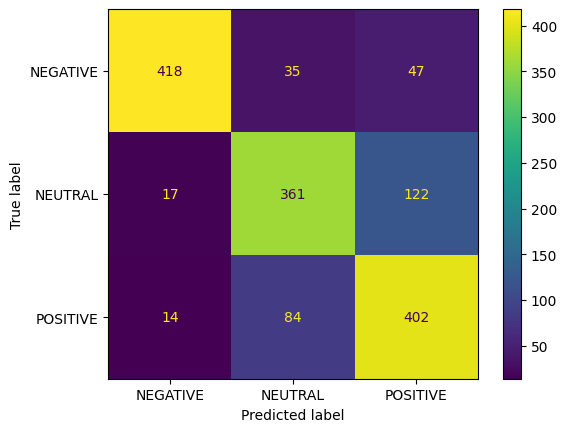

In [72]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_true=test_data.label, y_pred=prediction)
ConfusionMatrixDisplay(cm, display_labels=model.classes_).plot(values_format='.3g')

A pozitív és semleges osztályokat valamiért sokszor összekeveri... Nézzünk rá példákat a tanító adatbázison!

# Modell javítása új jellemzőkészlettel

Ha a szavak mellett szópárok (bigram) is jellemzők lennének, több információt adunk át a modellnek. Így például a 'not good' megjelenik jellemzőként és esélyt adunk a modellnek, hogy összefüggést tanuljon rá.

In [73]:
# CountVectorizernek átparaméterezésével új jellemzőkinyerést valósítunk meg, minden más ugyanaz marad
bigram_vectorizer = CountVectorizer(ngram_range=(1, 2), token_pattern=r'\b\w+\b', min_df=2)
# ngram_range mondja meg, hogy szavakat (unigram, 1gram) és egymás utáni szavakból álló párokat (bigram, 2gram) használjunk
# min_df=2 eldobja azokat a szavakat amik kevesebb, mint 2 dokumentumban fordult elő. Nagyon sok bigram van, ezzel csökkentjük a jellemzőkészlet dimenziószámát
# CountVectorizernek számos paramétere van, lásd: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

features_bigram = bigram_vectorizer.fit_transform(train_data.text)

cls = SGDClassifier(alpha=0.001) # új, üres osztályozó
model_bigram = cls.fit(features_bigram, train_data.label)
features_bigram

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 223063 stored elements and shape (9063, 24984)>

In [74]:
bigram_vectorizer.vocabulary_

{'hsbc': 10503,
 'sorry': 19872,
 'for': 8444,
 'aiding': 2139,
 'mexican': 14005,
 'drugs': 7276,
 'lords': 13157,
 'rogue': 18314,
 'states': 20149,
 'and': 2468,
 'terrorists': 20924,
 'http': 10566,
 'gu': 9620,
 'com': 5851,
 'p': 16295,
 '394tx': 926,
 'tw': 22763,
 'hsbc sorry': 10546,
 'sorry for': 19874,
 'for aiding': 8474,
 'aiding mexican': 2140,
 'mexican drugs': 14007,
 'drugs lords': 7277,
 'lords rogue': 13158,
 'rogue states': 18316,
 'states and': 20150,
 'and terrorists': 2661,
 'terrorists http': 20926,
 'http gu': 10647,
 'gu com': 9621,
 'com p': 5885,
 'p 394tx': 16299,
 '394tx tw': 927,
 'd': 6531,
 'or': 15994,
 '2003': 494,
 'see': 19112,
 'if': 10961,
 'you': 24755,
 'can': 4959,
 'spot': 20030,
 'the': 21108,
 'bmw': 4225,
 'motorrad': 14429,
 'france': 8776,
 'team': 20839,
 'thevent': 21674,
 'rider': 18186,
 'https': 10741,
 'www': 24518,
 'facebook': 7843,
 'photo': 16648,
 'php': 16666,
 'fbid': 7998,
 'set': 19278,
 'a': 1402,
 'type': 22821,
 '3': 806

In [75]:
prediction_bigram = model_bigram.predict(bigram_vectorizer.transform(test_data.text))

In [76]:
print(accuracy_score(y_true=test_data.label, y_pred=prediction_bigram))
print(classification_report(y_true=test_data.label, y_pred=prediction_bigram))

0.7846666666666666
              precision    recall  f1-score   support

    NEGATIVE       0.93      0.85      0.89       500
     NEUTRAL       0.74      0.72      0.73       500
    POSITIVE       0.71      0.78      0.74       500

    accuracy                           0.78      1500
   macro avg       0.79      0.78      0.79      1500
weighted avg       0.79      0.78      0.79      1500



Vannak olyan szavak amelyek sokszor fordulnak elő szövegekben, de szétválasztó erejük nincs, azaz ugyanúgy előfordulnak minden osztályban. Ilyenek például, sok más közt, a névelők. Ezek félreviszik az osztályozást (zajra tanulunk rá). A legegyszerűbb technika ennek kiküszöbölésére az ha a sima szógyakoriság (term frequency, TF) helyett normalizáljunk a szavak dokumentumok feletti gyakoriságávl (inverse document frequency, IDF). Lásd:  [TfIdf](http://www.tfidf.com)

In [77]:
# TfidfTransformer is egy új ellemzőkinyersi mód, minden más változatlan
from sklearn.feature_extraction.text import TfidfTransformer
vectorizer = CountVectorizer()
cv_counts = vectorizer.fit_transform(train_data.text)
idf_transformer = TfidfTransformer(use_idf=True).fit(cv_counts)
features_idf = idf_transformer.transform(cv_counts)
features_idf

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 147011 stored elements and shape (9063, 24285)>

In [78]:

cls = SGDClassifier()
model_idf = cls.fit(features_idf, train_data.label)

In [79]:
prediction_idf = model_idf.predict(idf_transformer.transform(vectorizer.transform(test_data.text)))

In [80]:
print(accuracy_score(y_true=test_data.label, y_pred=prediction_idf))
print(classification_report(y_true=test_data.label, y_pred=prediction_idf))

0.7873333333333333
              precision    recall  f1-score   support

    NEGATIVE       0.93      0.84      0.89       500
     NEUTRAL       0.75      0.73      0.74       500
    POSITIVE       0.71      0.79      0.74       500

    accuracy                           0.79      1500
   macro avg       0.79      0.79      0.79      1500
weighted avg       0.79      0.79      0.79      1500



Itt már kézzel fogható javulást tudtunk elérni.

# Model javítása előfeldolgozással

In [81]:
def preprocess(textcol):
    return textcol.replace('\d+', 'NUM',regex=True)

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-2245303236.py:2: SyntaxWarning: invalid escape sequence '\d'
  return textcol.replace('\d+', 'NUM',regex=True)


In [82]:
train_data.text = preprocess(train_data.text)
test_data.text  = preprocess(test_data.text)

In [83]:
train_data.text

,text
0,"HSBC 'sorry' for aiding Mexican drugs lords, r..."
1,Bol d'Or NUM. See if you can spot the BMW Moto...
2,NUM TOYOTA CAMRY LE (CLEAN TITLE) (Chelsea) $N...
3,Bank of America to cut execs in wealth-managem...
4,I just found out that lady gaga is number one ...
...,...
9058,Car is so packed I can only see out of half of...
9059,Yamaha Virago XVNUM custom This Yamaha Virago ...
9060,NUM Jeep Grand Cherokee Laredo at Ingram Park ...
9061,#Barclays Bank fined for lying. #Capitalism in...


Az [NLTK](https://www.nltk.org/) az egyik leggyakrabban használt python csomag szövegfeldolgozásban. A másik a [spaCy](https://spacy.io/). Kettejük egy összehasonlítása [itt](https://www.activestate.com/blog/natural-language-processing-nltk-vs-spacy/)

In [84]:
import nltk

Miért nem egyértelmű a tokenizálás? Miért léteznek különböző algoritmusok?

Azért mert különböző nyelveken másképp lehetnek a szóhatárok (magyar "-e"), például rövidítést jelentő pont a token része ("U.S.A." vagy "kft."), míg mondatvégi a írásjel nem. Továbbá a szöveg típusa is megkövetelhet különböző tokenizálókat, pl. szociális médiában az emotikonok és URLeket egyben kell tartni de a camelcase szavakat (pl. JoMunkahozIdoKell) tokenizáljuk, kémiai szövegekben a kötőjel egy molekula nevében nem szóhatár, stb.

In [89]:
text = """What can I say about this place. The staff of the restaurant is nice and the eggplant is not bad. Apart from that, very uninspired food, lack of atmosphere and too expensive. I am a staunch vegetarian and was sorely dissapointed with the veggie options on the menu. Will be the last time I visit, I recommend others to avoid."""

nltk_splitter = nltk.data.load('tokenizers/punkt/english.pickle') # Számos szöveget mondatra bontó algoritmus (splitter) van implementálva az NLTKban. A Punkt az egyik, ezt betöltjük.
nltk_tokenizer = nltk.tokenize.TreebankWordTokenizer() # Számos szavakra (tokenekre) bontó algoritmus (tokenizer) is implementálva van.

# text mondatai:
sentences = nltk_splitter.tokenize(text)

Sajnos ez így még nem működik. Az NLTK erőforrásfájlait külön le kell töltenünk a Colab-ba. Ha azok nincsenek ott hibaüzenettel elszállunk futtatás közben.

In [87]:
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

Most már működik! Futassuk újra a nltk_splitter inicializáló kódcellát!

In [90]:
sentences = nltk_splitter.tokenize(text) # a szöveget mondatokra bontjuk
sentences # mondatokat tartalmazó lista

['What can I say about this place.',
 'The staff of the restaurant is nice and the eggplant is not bad.',
 'Apart from that, very uninspired food, lack of atmosphere and too expensive.',
 'I am a staunch vegetarian and was sorely dissapointed with the veggie options on the menu.',
 'Will be the last time I visit, I recommend others to avoid.']

In [ ]:
tokenized_sentences = [nltk_tokenizer.tokenize(sent) for sent in sentences] # a mondatokat bejárjuk a for ciklussal és egyessével tokenizáljuk őket
tokenized_sentences # listák listája, amiben a mondatok szavai vannak

Egy másik fontos előfeldolgozási lépés a **szótövesítés (stemming, lemmatizáció)**. A cél, hogy a szavak különböző ragozott alakjait össze tudjuk vonni (pl. általában nem érdemes külön kezelni az 'asztalaitokra' és 'asztal' szóalakokat). A lemmatizáció az igazi nyelvtani értelemben vett szótő meghatározását jelenti. Ez nagyon bonyolult feladat tud lenni bizonyos nyelveken, pl. a magyarban ahol tőhangváltás is van (a 'madarak' szó szótöve a 'madár'). De sokszor elég a szótőnek egy "közelítése", azaz egyszerű szabályokkal lecseréljük a szóalak végi karaktereket más karakterre. Ezt a közelítő (butább, de sokkal egyszerűbb és gyorsabb) hívjuk stemmelésnek ([részletesen](https://www.datacamp.com/community/tutorials/stemming-lemmatization-python))

In [ ]:
from nltk.stem.wordnet import WordNetLemmatizer # egy angol igazi lemmatizáló
nltk.download('wordnet') # erőforrást itt is le kell tölteni hozzá
lemmatizer = WordNetLemmatizer()

In [ ]:
lemmatizer.lemmatize("companies")

In [ ]:
from nltk.stem import PorterStemmer # egy angol gyors stemmer (nincs erőforrásfájl, a szabályok a kódban vannk)
stemmer = PorterStemmer()

In [ ]:
stemmer.stem("companies") # 'es' végződés levágása sokszor működik többesszámú főneveknél. A 'companies' esetén "buta".

# Gyakorló feladatok

Az órai adatbázison hajts végre egy kísérletet (tanítás, predikció és kiértékelés) ahol

*   a szavak szótövét vagy stemjét használjuk a szózsák modellben!
*   egy másik lineáris gépet, a Logisztkus Regresszió osztályozó algoritmust használunk (Logistic Regression Classifier).

Írd ki, hogy mekkora szótár lesz így illetve mennyi így az accuracy!

---
**Következő két hétben:**
Az elmúlt 10+ évben a szózsák modellt felváltották a szóbeágyazás alapú reprezentációk, pl. [word2vec](https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial) illetve az ezeket használó deep learning osztályozók, konvolúciós és rekurrens neurális hálózatok. Aztán 2019 óta nagy nyelvi modellek nyertek teret, mint a BERT és a GPT

In [110]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier



train_data = pd.read_csv('https://github.com/rfarkas/student_data/raw/main/sentiment/train.tsv', sep='\t')
vectorizer = CountVectorizer()

test_data = pd.read_csv('https://raw.githubusercontent.com/rfarkas/student_data/main/sentiment/test.tsv', sep='\t')
test_features = vectorizer.fit_transform(test_data.text)

vectorizer.fit(train_data.text)
features = vectorizer.transform(train_data.text)

sb = SelectKBest(chi2, k=1000)
best_features = sb.fit_transform(features, train_data.label)

cls = SGDClassifier()
model = cls.fit(best_features, train_data.label)

pred = model.predict(test_features)

accuracy_score(test_data.label, pred)


ValueError: X has 7271 features, but SGDClassifier is expecting 1000 features as input.